[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nahuelalmeira/graphMachineLearning/blob/main/notebooks/Notebook3_Prediccion_de_Enlaces.ipynb)

<img src="./figuras/cropped-Logos-diplomatura-hd-2.png" width="500"/>

# Predicción de enlaces

## Configuración general

In [23]:
import pandas as pd
import numpy as np
import random
import networkx as nx
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from pathlib import Path
data_dir = Path("../data")

## Dataset

El dataset con el que vamos a trabajar es un subgrafo de Facebook. Los nodos representan cuentas asociadas a páginas de comida y chefs de renombre, mientras que las conecciones corresponden a la relación de amistad establecida por la red social.

Los datos están disponibles en este [enlace](http://networkrepository.com/fb-pages-food.php).

Cargamos los datos

In [24]:
fb_df = pd.read_csv(data_dir / "fb-pages-food.edges", names=["node_1", "node_2"])
fb_df = fb_df.sort_values(by=["node_1", "node_2"])
print("Shape:", fb_df.shape)
fb_df.head()

Shape: (2102, 2)


,node_1,node_2
1,0,58
2,0,132
0,0,276
4,0,398
5,0,555


In [25]:
# Remuevo self-loops (probablemente sean errores en los datos)
fb_df = fb_df[(fb_df["node_1"] != fb_df["node_2"])]

Construimos el grafo

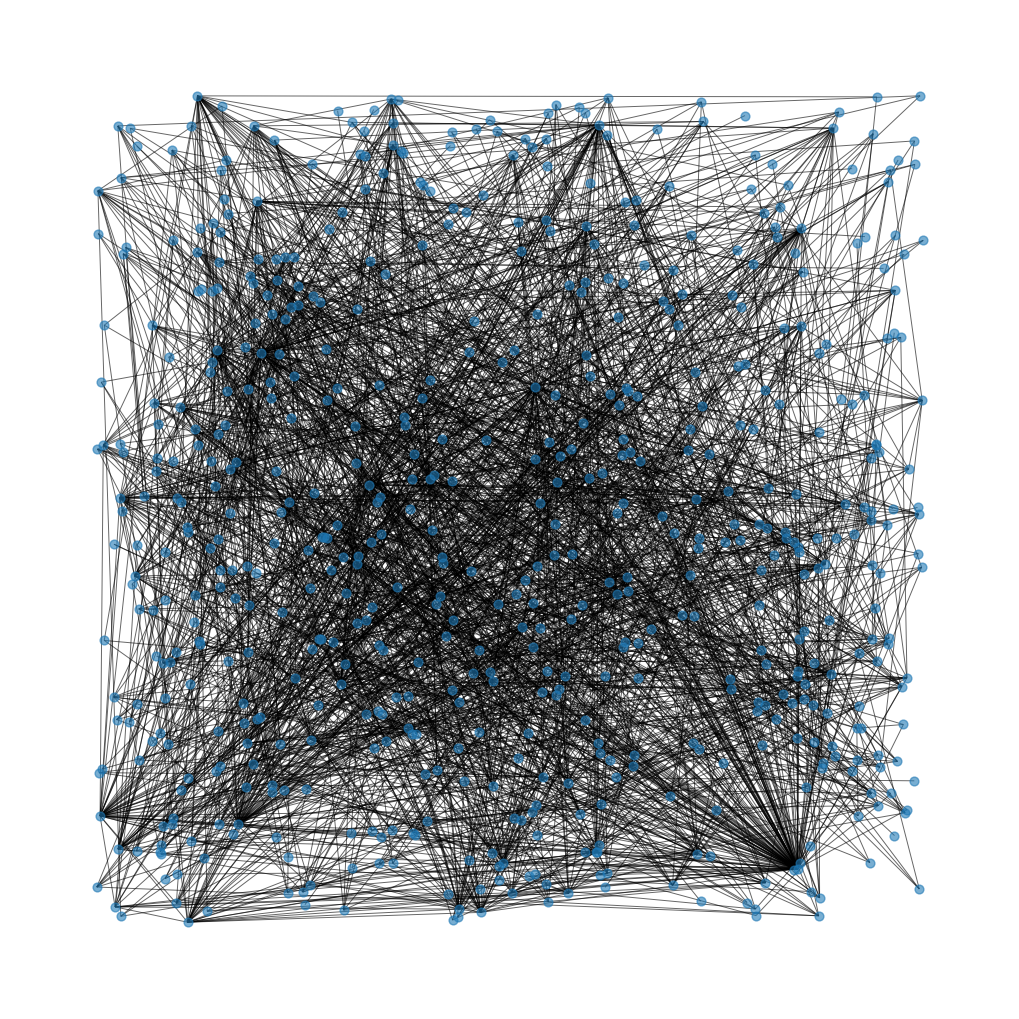

In [26]:
# create graph
G = nx.from_pandas_edgelist(fb_df, "node_1", "node_2")

# plot graph
plt.figure(figsize=(10, 10))

pos = nx.random_layout(G, seed=23)
nx.draw(G, with_labels=False,  pos=pos, node_size=40, alpha=0.6, width=0.7)

plt.show()

Extraemos la matriz de adyacencia

In [27]:
# combine all nodes in a list
node_list = [v for v in G.nodes()]

# remove duplicate items from the list
node_list = list(dict.fromkeys(node_list))

# build adjacency matrix
adj_G = nx.to_numpy_matrix(G, nodelist = node_list)

In [28]:
adj_G.shape

(620, 620)

Determinamos los pares de nodos que comparten vecinos y que no están conectados

In [29]:
# get unconnected node-pairs
all_unconnected_pairs = []

# traverse adjacency matrix
for i in tqdm(range(adj_G.shape[0])):
    for j in range(i+1, adj_G.shape[1]):
        if nx.shortest_path_length(G, i, j) <=2:
            if adj_G[i,j] == 0:
                all_unconnected_pairs.append([node_list[i],node_list[j]])

100%|██████████| 620/620 [00:08<00:00, 76.52it/s] 


In [30]:
len(all_unconnected_pairs)

19046

Almacenamos los pares de nodos no conectados en un dataframe (sampleo negativo)

In [31]:
node_1_unlinked = [i[0] for i in all_unconnected_pairs]
node_2_unlinked = [i[1] for i in all_unconnected_pairs]

data = pd.DataFrame({'node_1':node_1_unlinked, 
                     'node_2':node_2_unlinked})

# add target variable 'link'
data['link'] = 0

Removemos pares de nodos conectados (sampleo positivo)

In [32]:
initial_node_count = len(G.nodes)

fb_df_temp = fb_df.copy()

# empty list to store removable links
omissible_links_index = []

for i in tqdm(fb_df.index.values):

  # remove a node pair and build a new graph
  G_temp = nx.from_pandas_edgelist(fb_df_temp.drop(index = i), "node_1", "node_2", create_using=nx.Graph())

  # check there is no spliting of graph and number of nodes is same
  if (nx.number_connected_components(G_temp) == 1) and (len(G_temp.nodes) == initial_node_count):
    omissible_links_index.append(i)
    fb_df_temp = fb_df_temp.drop(index = i)

100%|██████████| 2091/2091 [00:09<00:00, 226.63it/s]


In [33]:
len(omissible_links_index)

1472

Almacenamos los pares de nodos conectados en el dataframe

In [34]:
# create dataframe of removable edges
fb_df_ghost = fb_df.loc[omissible_links_index]

# add the target variable 'link'
fb_df_ghost['link'] = 1

data = pd.concat([data, fb_df_ghost], ignore_index=True)
data = data.set_index(["node_1", "node_2"])

In [35]:
data['link'].value_counts()

0    19046
1     1472
Name: link, dtype: int64

In [36]:
# drop removable edges
fb_df_partial = fb_df.drop(index=fb_df_ghost.index.values)

# build graph
G_data = nx.from_pandas_edgelist(fb_df_partial, "node_1", "node_2", create_using=nx.Graph())

In [37]:
algorithms = {
    "resource": nx.resource_allocation_index,
    "jaccard": nx.jaccard_coefficient,
    "adamic_adar": nx.adamic_adar_index,
}

metrics = data.copy()
for algo_name, algorithm in algorithms.items():
    metric = pd.DataFrame(
        list(algorithm(G_data)),
        columns=["source", "target", algo_name]
    ).set_index(keys=["source", "target"])
    metrics[algo_name] = metric
metrics = metrics.fillna(0)
metrics.head()

link  resource  jaccard  adamic_adar
node_1 node_2                                      
0      608        0       0.0      0.0          0.0
       518        0       0.0      0.0          0.0
       305        0       0.0      0.0          0.0
       107        0       0.0      0.0          0.0
       189        0       0.0      0.0          0.0

In [38]:
metrics.groupby(by="link").mean()

,resource,jaccard,adamic_adar
link,,,
0,0.000808,0.003643,0.003117
1,0.027134,0.075528,0.095266


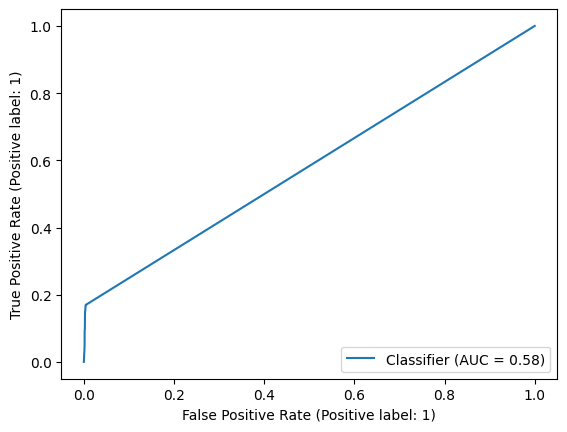

In [39]:
RocCurveDisplay.from_predictions(metrics["link"], metrics["resource"]);

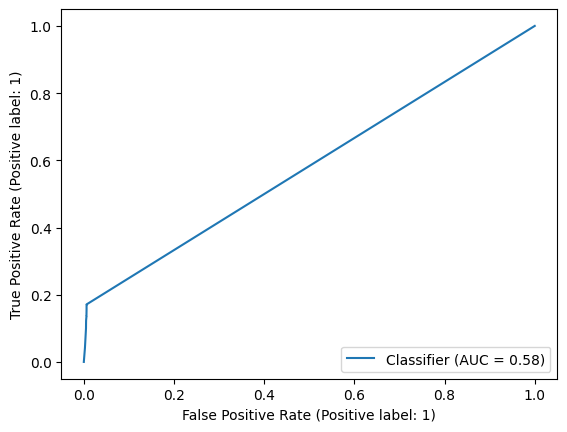

In [40]:
RocCurveDisplay.from_predictions(metrics["link"], metrics["jaccard"]);

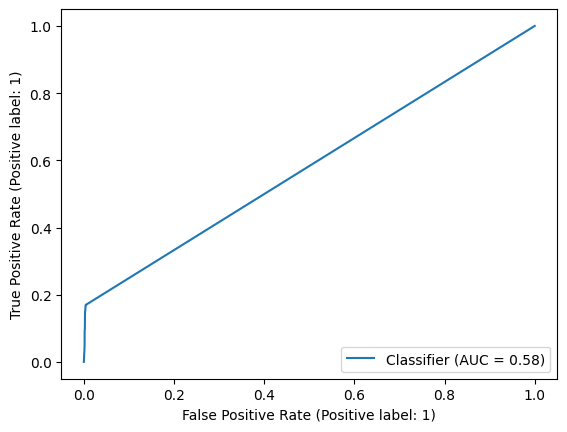

In [41]:
RocCurveDisplay.from_predictions(metrics["link"], metrics["adamic_adar"]);

# Extracción de features mediante node embeddings

In [43]:
from node2vec import Node2Vec

# Generate walks
node2vec = Node2Vec(G_data, dimensions=100, walk_length=16, num_walks=50)

# train node2vec model
n2w_model = node2vec.fit(window=7, min_count=1)

Computing transition probabilities:   0%|          | 0/620 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 50/50 [00:02<00:00, 21.99it/s]


In [44]:
x = np.array([
    n2w_model.wv[str(i)] + n2w_model.wv[str(j)]
    for i,j in zip(data.index.get_level_values(0), data.index.get_level_values(1))
])

### Predicción utilizando modelos de aprendizaje supervisado

In [45]:
xtrain, xtest, ytrain, ytest = train_test_split(x, data['link'], 
                                                test_size = 0.3, 
                                                random_state = 35)

In [46]:
lr = LogisticRegression(class_weight="balanced", max_iter=1000)

lr.fit(xtrain, ytrain)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [47]:
predictions = lr.predict_proba(xtest)

In [48]:
roc_auc_score(ytest, predictions[:,1])

0.8500265732171833

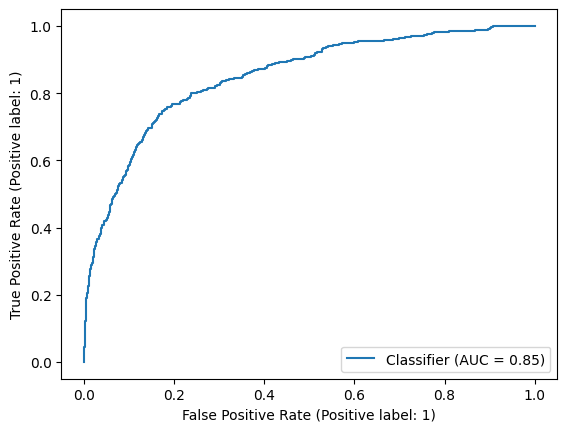

In [49]:
RocCurveDisplay.from_predictions(ytest, predictions[:,1]);

In [50]:
import lightgbm as lgbm

train_data = lgbm.Dataset(xtrain, ytrain)
test_data = lgbm.Dataset(xtest, ytest)

# define parameters
parameters = {
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'num_threads' : 2,
    'seed' : 76
}

# train lightGBM model
model = lgbm.train(parameters,
                   train_data,
                   valid_sets=test_data,
                   num_boost_round=1000,
                   early_stopping_rounds=20)

/home/nahuel/anaconda3/envs/graphML/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 1039, number of negative: 13323
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 14362, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.072344 -> initscore=-2.551233
[LightGBM] [Info] Start training from score -2.551233
[1]	valid_0's auc: 0.812263
Training until validation scores don't improve for 20 rounds
[2]	valid_0's auc: 0.850282
[3]	valid_0's auc: 0.863959
[4]	valid_0's auc: 0.875084
[5]	valid_0's auc: 0.877863
[6]	valid_0's auc: 0.886961
[7]	valid_0's auc: 0.890043
[8]	valid_0's auc: 0.892099
[9]	valid_0's auc: 0.895641
[10]	valid_0's auc: 0.897012
[11]	valid_0's auc: 0.899405
[12]	valid_0's auc: 0.902887
[13]	valid_0's auc: 0.905257
[14]	valid_0's auc: 0.905255
[15]	valid_0's auc: 0.906027
[16]	valid_0's 